In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
import time

%matplotlib inline

In [0]:
!wget -O dog_data.zip "https://github.com/abhinavjha98/dog_dataset/archive/master.zip"
!unzip dog_data.zip

--2019-08-12 13:13:34--  https://github.com/abhinavjha98/dog_dataset/archive/master.zip
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/abhinavjha98/dog_dataset/zip/master [following]
--2019-08-12 13:13:35--  https://codeload.github.com/abhinavjha98/dog_dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dog_data.zip’

dog_data.zip            [         <=>        ]  23.83M  8.12MB/s    in 2.9s    

2019-08-12 13:13:38 (8.12 MB/s) - ‘dog_data.zip’ saved [24987146]

Archive:  dog_data.zip
db6234ae18b57f78cb7ecf477871771af6f351cb
replace dog_dataset-master/test/1/16.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A

In [0]:
data_dir = 'dog_dataset-master'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
mean = [0.485, 0.456, 0.406]
stdev = [0.229, 0.224, 0.225]

In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, stdev)])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev)])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean, stdev)])

# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': train_transforms,
    'test': test_transforms,
    'valid': validation_transforms
}

In [0]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=train_transforms),
    'test': datasets.ImageFolder(test_dir, transform=test_transforms),
    'valid': datasets.ImageFolder(valid_dir, transform=validation_transforms)
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], 128, shuffle=True),
    'test': torch.utils.data.DataLoader(image_datasets['test'], 32, shuffle=True),
    'valid': torch.utils.data.DataLoader(image_datasets['valid'], 32, shuffle=True)
}

In [0]:
import json

with open('cat_to name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
print(cat_to_name)

{'1': 'beagle', '2': 'golden_ret', '3': 'rott', '4': 'hope'}


In [0]:
epochs = 5
drop_prob = 0.1
hidden_dim = 1024
output_dim = len(cat_to_name)
print_every = 10

In [0]:
def build_network():
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    classifier = nn.Sequential(
        nn.Linear(model.fc.in_features, hidden_dim),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.Linear(hidden_dim, output_dim),
        nn.LogSoftmax(dim=1)
    )

    model.fc = classifier
    model.cuda()
    
    return model

In [0]:
clf_nn = build_network()
print(clf_nn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(clf_nn.fc.parameters())

In [0]:
def train(epochs, print_every):
    clf_nn.to('cuda')
    steps = 0
    for e in range(epochs):
        running_loss = 0
        print(f"Epoch {e + 1} -------------------------------------------")
        for imgs, labels in dataloaders['train']:
            steps += 1
            imgs, labels = imgs.to('cuda'), labels.to('cuda')
            
            optimizer.zero_grad()
            
            outputs = clf_nn.forward(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if(steps % print_every == 0):
                t_loss = running_loss / print_every
                v_loss, v_acc = validate(dataloaders['valid'])
                print(f"Training Loss: {t_loss:.4f} Validation Loss: {v_loss:.4f} Validation Acc: {v_acc:.4f}")
                running_loss = 0

In [0]:
train(epochs, print_every)

Epoch 1 -------------------------------------------
Epoch 2 -------------------------------------------
Epoch 3 -------------------------------------------
Epoch 4 -------------------------------------------
Epoch 5 -------------------------------------------


In [0]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    clf_nn.eval()
    clf_nn.to('cuda')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = clf_nn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(dataloaders['test'])

Accuracy of the network on the test images: 73 %


In [0]:
clf_nn.class_to_idx = image_datasets['train'].class_to_idx
clf_nn.cpu()

checkpoint = {
    'arch': 'resnet18',
    'hidden_dim': hidden_dim,
    'output_dim': output_dim,
    'class_to_idx': clf_nn.class_to_idx,
    'state_dict': clf_nn.state_dict()
}

torch.save(checkpoint, 'checkpoint_resnet18.pth')

In [0]:
def load_pretrained_model(model_path):
    checkpoint = torch.load(model_path)
    model = build_network()
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return model

pretrained_model = load_pretrained_model('./checkpoint_resnet18.pth')
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    with Image.open(image_path) as image:  
        image = data_transforms['test'](image).numpy()
        
    return image

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

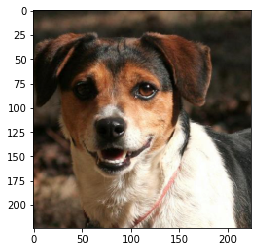

In [0]:
imshow(process_image('/content/dog_dataset-master/test/1/16.jpg'))

In [0]:
idx_to_class = {clf_nn.class_to_idx[k]: k for k in clf_nn.class_to_idx}
idx_to_class

{0: '1', 1: '2', 2: '3', 3: '4'}

In [0]:
def predict(image_path, model, topk=4):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cuda()
    model.eval()
    img = process_image(image_path)
    img = torch.from_numpy(img).float().cuda()
    img = torch.unsqueeze(img, dim=0)
    output = model.forward(img)
    preds = torch.exp(output).topk(topk)
    probs = preds[0][0].cpu().data.numpy()
    classes = preds[1][0].cpu().data.numpy()
    topk_labels = [idx_to_class[i] for i in classes]
    return probs.tolist(), topk_labels

In [0]:
[predict('/content/dog_dataset-master/test/2/17.jpg', pretrained_model)]

[([0.9813449382781982,
   0.014844158664345741,
   0.0019870358519256115,
   0.0018236569594591856],
  ['2', '1', '3', '4'])]

In [0]:
# TODO: Display an image along with the top 5 classes
def check_sanity(img_path):
    prob, classes = predict(img_path, pretrained_model)
    max_index = np.argmax(prob)
    max_probability = prob[max_index]
    label = classes[max_index]

    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
    ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

    image = Image.open(img_path)
    ax1.axis('off')
    ax1.set_title(cat_to_name[label])
    ax1.imshow(image)

    labels = []
    for cl in classes:
        labels.append(cat_to_name[cl])

    y_pos = np.arange(4)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(labels)
    ax2.set_xlabel('Probability')
    ax2.invert_yaxis()
    ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

    plt.show()

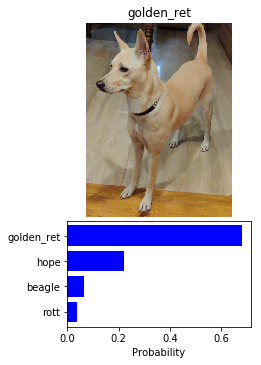

In [0]:

check_sanity('/content/dog_dataset-master/test/4/11.jpg')

In [0]:
grades=[4,43,67,38,33]
res=[]
def gradingStudents(grades):
    for grade in grades:
        if grade >= 38:
        # Here, we are only ever calculating 'grade mod 5' once:
          mod5 = grade % 5
        
          if mod5 >= 3:
              grade = grade + (5 - mod5)
        
    print(grade)